# Factor Selection

In [53]:
from WindPy import w
import pandas as pd
import numpy as np
import os
import shutil
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.api import het_white, het_breuschpagan
from statsmodels.stats.sandwich_covariance import cov_hac
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.dates as mdates
import matplotlib

In [55]:
from matplotlib.font_manager import FontProperties 
matplotlib.pyplot.rcParams['font.sans-serif']=['simhei']
font_path = '/Users/miaxiaozile/Library/Fonts/SimHei.ttf'
font_prop = FontProperties(fname=font_path)
matplotlib.rcParams['axes.unicode_minus']=False

In [2]:
w.start()

2024-07-14 17:32:53.275 Python[3356:146568] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


Wind.Cosmos.Base V1.7 compiled time is Apr 17 2023, BuildType:Release, CPUArch:X64, GCC Version:Apple LLVM 13.0.0 (clang-1300.0.29.30)
Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2021 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [3]:
start_date = "2009-01-01" # actually from 2010, extract data for preprocessing
end_date = "2024-06-30"
pd.set_option('display.max_rows', 30)

In [4]:
# takes a dict of indicators and their corresponding ticker in Wind to
# create a DataFrame containing the data extracted from Wind API
def extract_inds(inds, start_date=start_date):
    df = pd.DataFrame()
    for ind in inds:
        raw = w.edb(inds[ind], start_date, end_date, Period="M")
        # Extract data from the Wind API response
        times = raw.Times
        data = raw.Data[0]
        # Convert times to pandas datetime format
        times = pd.to_datetime([str(time) for time in times], format="%Y-%m-%d")
        
        # Create a temporary DataFrame for the current indicator
        temp_df = pd.DataFrame(data, index=times, columns=[ind])
        
        # Combine the temporary DataFrame with the main DataFrame
        if df.empty:
            df = temp_df
        else:
            df = df.join(temp_df, how='outer')
    return df

In [5]:
# handles specifically when there are weird missing data
def extract_inds_irr(inds, start_date=start_date):
    dfs = []
    for ind in inds:
        raw = w.edb(inds[ind], start_date, end_date, Period="M")
        # Extract data from the Wind API response
        times = raw.Times
        data = raw.Data[0]
        # Convert times to pandas datetime format
        times = pd.to_datetime([str(time) for time in times], format="%Y-%m-%d")
        
        # Create a temporary DataFrame for the current indicator
        temp_df = pd.DataFrame(data, index=times, columns=[ind]).to_period('M')
        dfs.append(temp_df)
        
    # Concatenate all dataframes along the columns, preserving all data
    combined_df = pd.concat(dfs, axis=1) 
    return combined_df

In [6]:
def lag_data(df, periods=1):
    df_lagged = df.shift(periods)
    df_lagged = df_lagged.iloc[periods:]  # Remove the first rows
    return df_lagged

In [7]:
def apply_x11(df, columns, x13as_path='/usr/local/bin/x13as'):
    tempdir = os.path.join(os.getcwd(), 'x13as_temp')
    os.makedirs(tempdir, exist_ok=True)

    df_adjusted = df.copy()
    for column in columns:
        ts = df[column].asfreq('M')
        
        # Handle zero or negative values
        min_value = ts.min()
        shift_value = abs(min_value) + 1 if min_value <= 0 else 0
        ts_shifted = ts + shift_value
        
        try:
            result = sm.tsa.x13_arima_analysis(ts_shifted, x12path=x13as_path, tempdir=tempdir)
            if result is None:
                raise ValueError(f"X-13ARIMA-SEATS returned None for column: {column}")
            
            # Adjust the seasonally adjusted data back
            df_adjusted[column] = result.seasadj - shift_value
            
        except Exception as e:
            print(f"Error processing column {column}: {e}")
            
            # Read and print the .err file for more details
            err_file_path = os.path.join(tempdir, 'x13as.err')
            if os.path.exists(err_file_path):
                with open(err_file_path, 'r') as err_file:
                    print(f"Error file content for column {column}:")
                    print(err_file.read())
            continue
    
    # Cleanup temporary directory
    shutil.rmtree(tempdir)

    return df_adjusted

In [8]:
# YoY Change Processing
def yoy(df, columns):
    df_yoy = df.copy()
    for column in columns:
        df_yoy[column] = (df[column] - df[column].shift(12)) / df[column].shift(12) * 100
    df_yoy = df_yoy.iloc[12:]  # Remove the first 12 rows where the shift operation would result in NaN
    return df_yoy

In [9]:
# for factor selection, regress on the exchang rate to observe Beta, T-Value, and R-Squared
# and record the median values after 1000 iterations
def regress(indicator_df, forex_df, target_column='USD/CNY Central Parity Rate', n_iterations=1000, min_period_length=24):
    # Initialize a DataFrame to store regression results
    forex_df.index = indicator_df.index
    results = []

    for i in range(n_iterations):
        # Resample with replacement
        sample_indices = np.random.choice(indicator_df.index, size=len(indicator_df), replace=True)
        sample_growth_df = indicator_df.loc[sample_indices]
        sample_forex_df = forex_df.loc[sample_indices]
        
        # Randomly select start and end dates
        start_idx = np.random.randint(0, len(sample_growth_df) - min_period_length)
        end_idx = start_idx + min_period_length
        
        # Subset the data to ensure period longer than 2 years
        sample_growth_period = sample_growth_df.iloc[start_idx:end_idx]
        sample_forex_period = sample_forex_df.iloc[start_idx:end_idx]
        
        # Perform regression for each indicator
        for indicator in indicator_df.columns:
            X = sample_growth_period[[indicator]]
            X = sm.add_constant(X)
            y = sample_forex_period[target_column]
            
            model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
            beta = model.params[indicator]
            t_value = model.tvalues[indicator]
            r_squared = model.rsquared
            
            # Append the results
            results.append({
                'Indicator': indicator,
                'Beta': beta,
                'T-Value': t_value,
                'R-Squared(%)': r_squared * 100  # Convert to percentage
            })
            
    # Convert results to DataFrame
    growth_results_df = pd.DataFrame(results)

    # Compute median values
    growth_median_results = growth_results_df.groupby('Indicator').median().reset_index()

    # Format the median results
    growth_median_results['Beta'] = growth_median_results['Beta'].map("{:.2f}".format)
    growth_median_results['T-Value'] = growth_median_results['T-Value'].map("{:.2f}".format)
    growth_median_results['R-Squared(%)'] = growth_median_results['R-Squared(%)'].map("{:.2f}%".format)

    return growth_median_results

In [10]:
# Get USD/CNH Exchange Rate
fx_data = w.edb("M0000185", start_date, end_date, Period="M")
# Parse the data
times = fx_data.Times
data = fx_data.Data[0]
times = pd.to_datetime([str(time) for time in times], format="%Y-%m-%d")

# Construct the DataFrame
df_forex = pd.DataFrame(data, index=times, columns=["USD/CNY Central Parity Rate"])
df_fx_nonyoy = df_forex.iloc[12:]
df_forex = yoy(df_forex, df_forex.columns)
df_forex = df_forex[df_forex.index <= end_date]

# Display the DataFrame
df_forex

,USD/CNY Central Parity Rate
2010-01-29,-0.160866
2010-02-26,-0.160868
2010-03-31,-0.140435
2010-04-30,0.019048
2010-05-31,-0.064399
...,...
2024-02-29,2.182137
2024-03-29,3.249560
2024-04-30,2.632871
2024-05-31,0.377007


In [11]:
# df_forex.to_csv("/Users/miaxiaozile/Downloads/$/forex-project/data/fx_yoy.csv")
# df_fx_nonyoy.to_csv("/Users/miaxiaozile/Downloads/$/forex-project/data/fx.csv")


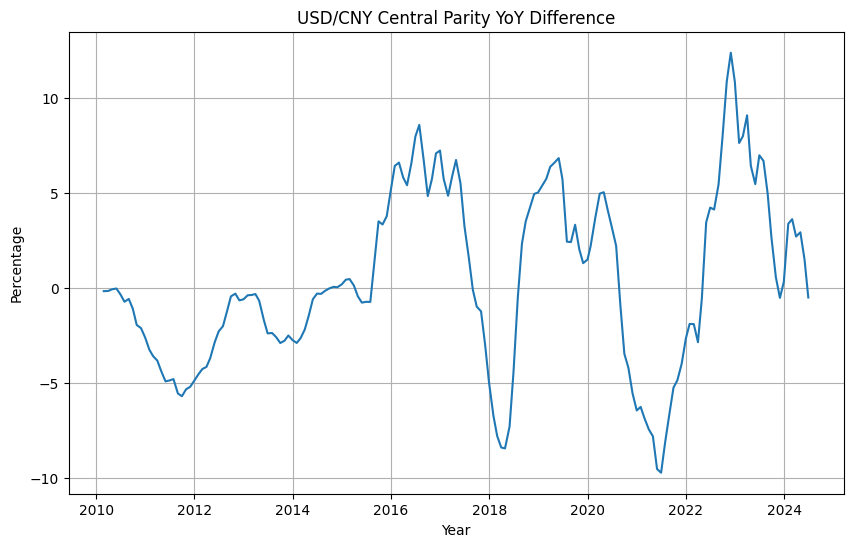

In [12]:
smoothed_fx = df_forex.rolling(window=2).mean()
plt.figure(figsize=(10, 6))
plt.plot(smoothed_fx.index, smoothed_fx[["USD/CNY Central Parity Rate"]])
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('USD/CNY Central Parity YoY Difference')
plt.grid(True)
plt.show()

In [13]:
def combine_factors(df1, columns_df1, df2=None, columns_df2=None, fx_rate = df_forex['USD/CNY Central Parity Rate']):
    inverse_volatilities = {}
    columns = {}

    # Process columns from df1
    for column in columns_df1:
        series = df1[column]
        # correlation = series.corr(fx_rate)
        # if correlation < 0:
        #    series = -series  # Invert the series if correlation is negative
        inverse_volatilities[column] = 1 / series.std()
        columns[column] = series

    # Process columns from df2 if provided
    if df2 is not None and columns_df2 is not None:
        for column in columns_df2:
            series = df2[column]
            # correlation = series.corr(fx_rate)
            #if correlation < 0:
            #   series = -series  # Invert the series if correlation is negative
            inverse_volatilities[column] = 1 / series.std()
            columns[column] = series

    total_inverse_volatility = sum(inverse_volatilities.values())

    weights = {key: inv_vol / total_inverse_volatility for key, inv_vol in inverse_volatilities.items()}

    combined_factor = sum(weights[key] * columns[key] for key in columns)

    return combined_factor, weights

In [14]:
# Function to calculate rolling average and plot the data
def plot_smoothed_data(category, factor, df, column, window_size=2):
    # Calculate rolling average (smoothing)
    smoothed_serie = df[column].rolling(window=window_size).mean()
    smoothed_factor = factor.rolling(window=window_size).mean()

    if isinstance(df.index, pd.PeriodIndex):
        # Convert PeriodIndex to DatetimeIndex for plotting
        smoothed_serie.index = smoothed_serie.index.to_timestamp()
        smoothed_factor.index = smoothed_factor.index.to_timestamp()

    # Plotting the data
    plt.figure(figsize=(10, 6))
    plt.plot(smoothed_serie.index, smoothed_serie, label=f'{column} (Smoothed)', color="slategray")
    plt.plot(smoothed_factor.index, smoothed_factor, label=f'{category} Factor (Smoothed)', color="crimson")
    plt.xlabel('Year')
    plt.ylabel('% Change')
    plt.title(f'{category} Factor vs. {column}')
    plt.legend()
    plt.grid(True)

    # Format x-axis to show only year
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    plt.show()

## Growth Factor

In [15]:
# consider key growth indicators for China
china_growth_inds = {
    # production method
    # general macro indicators
    'GDP(%)': 'M0039354',
    'Industrial_Added_Value_(%)': 'M0000545',
    'PMI': 'M0017126',
    'Manufacturing_PMI': 'M0017127',
    'Manufacturing_PMI:New_Orders': 'M0017128',
    # by industry
    'Electricity_Production(%)': 'S0027013',
    'Output:Cement(%)': 'S0027703',
    'Output:Crude_Steel(%)': 'S0027375',
    'Output:Motor_Vehicles(%)': 'S0027908',
    'Railway_Freight_Traffic(%)': 'S0036034',
    # expenditure method
    # investments
    'FAI(%)': 'M0000273',
    'Completed_Investment_in_Real_Estate_Development(%)': 'S0029657',
    'FAI:Infrastructure_Investment(%)': 'M5440435',
    'FAI:Manufacturing(%)': 'M0000357',
    # consumption
    'Total_Retail_Sales_of_Consumer_Goods(%)': 'M0001428',
    'Sales:Vehicle(%)': 'S6114593',
    'Sales:Excavators(%)': 'S6002167',
    'Floor_Space_of_Commercial_Buildings_Sold(%)': 'S0073300',
    'Total_Sales_of_Commercial_Buildings(%)': 'S0049591',
    # net exports
    'Imports_and_Exports(%)': 'M0000605',
    'Exports(%)': 'M0000607',
    'Imports(%)': 'M0000609',
    'Exports_USA(%)': 'M0008499',
    # income method
    'Govt_Revenue(%)': 'M0046169',
    'Industrial_Enterprise:Total_Profits(%)': 'M0000557'
}
# for standardizing the PMI data
china_nonyoy_cols = ['PMI', 'Manufacturing_PMI', 'Manufacturing_PMI:New_Orders']

In [16]:
# actual step retrieving data from Wind API
df_china_growth = extract_inds(china_growth_inds)
# df_china_growth = lag_data(df_china_growth)  # lag data by 1 period
df_china_growth = df_china_growth.interpolate(method="linear", limit_direction="both")  # interpolate missing values
df_china_growth = apply_x11(df_china_growth, df_china_growth.columns[1:])
df_china_growth = yoy(df_china_growth, china_nonyoy_cols)
df_china_growth.head(10)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: The covariance matrix of the ARMA parameters is singular,
          so the standard errors and the correlation matrix of the ARMA
          parameters will not be printed out.
  warn(errors, X13Warning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)
/Library/Frameworks/Python.framework/Versions/3.12/li

,GDP(%),Industrial_Added_Value_(%),PMI,Manufacturing_PMI,Manufacturing_PMI:New_Orders,Electricity_Production(%),Output:Cement(%),Output:Crude_Steel(%),Output:Motor_Vehicles(%),Railway_Freight_Traffic(%),...,Sales:Vehicle(%),Sales:Excavators(%),Floor_Space_of_Commercial_Buildings_Sold(%),Total_Sales_of_Commercial_Buildings(%),Imports_and_Exports(%),Exports(%),Imports(%),Exports_USA(%),Govt_Revenue(%),Industrial_Enterprise:Total_Profits(%)
2010-01-31,12.000000,28.840374,22.822845,33.097525,33.093509,34.792892,51.283733,26.817048,142.935468,15.400471,...,122.272005,238.224980,39.368366,71.333882,42.452960,13.854516,90.276762,6.870578,40.841801,78.809221
2010-02-28,12.100000,12.691783,5.920342,5.877073,6.520292,6.841327,7.096886,21.389194,40.561068,16.223924,...,42.715974,1.945196,39.103343,69.109625,44.918457,40.758183,47.523191,21.070622,31.276786,118.870863
2010-03-31,12.200000,17.856353,5.421829,2.774740,6.863928,17.085116,14.247354,22.014727,49.437856,16.726527,...,55.381005,124.466549,36.461095,58.436193,40.606504,19.146737,62.429735,19.630348,32.061149,106.359745
2010-04-30,11.733333,18.328453,4.345898,3.119198,5.051338,22.983789,16.610255,28.783555,33.644734,14.867500,...,37.785179,105.243116,33.655445,56.348778,38.851225,29.686710,51.420908,19.477848,33.814133,95.852612
2010-05-31,11.266667,16.647093,1.524377,2.302787,-2.522878,19.859088,18.607215,21.945083,29.010733,12.284384,...,30.967699,110.489917,23.725390,41.187636,47.047436,49.380338,49.351825,24.609720,30.046255,84.398973
2010-06-30,10.800000,13.352383,-2.103968,-2.218611,-6.059315,11.237980,13.975653,10.270100,19.262577,11.507903,...,27.774105,79.418706,16.632384,28.390268,39.620222,43.651739,33.569337,28.132690,27.777813,75.947135
2010-07-31,10.500000,13.856050,-3.958889,-7.983423,-8.131378,12.050930,15.638939,2.929162,19.983355,10.196916,...,16.228710,57.252653,10.743676,19.037043,32.481012,40.939923,23.545227,29.490339,26.284650,67.155246
2010-08-31,10.200000,14.281487,-4.288623,-8.184797,-5.755194,12.690417,12.278727,0.064703,11.951302,10.076064,...,17.509789,44.831937,6.806111,13.046301,35.864099,37.489868,35.071515,31.400055,24.311182,57.212819
2010-09-30,9.900000,13.490768,-0.901760,-2.742671,-0.948971,9.277815,9.341928,-5.183410,20.599429,7.394590,...,16.399901,58.793120,7.720751,14.891609,26.010615,30.203861,23.607177,31.117919,23.232228,53.832458
2010-10-31,9.900000,13.023332,-0.898679,-3.847157,-0.424713,6.176742,8.772170,-4.031552,24.636517,7.222580,...,24.820561,44.001674,7.824679,14.692877,24.774456,28.488098,24.100914,29.761738,22.409959,49.488162


In [17]:
china_growth_ctrb = regress(df_china_growth, df_forex)
china_growth_ctrb

,Indicator,Beta,T-Value,R-Squared(%)
0,Completed_Investment_in_Real_Estate_Developmen...,-0.20,-4.20,32.49%
1,Electricity_Production(%),-0.26,-1.90,10.33%
2,Exports(%),-0.17,-3.46,29.46%
3,Exports_USA(%),-0.18,-5.35,40.42%
4,FAI(%),-0.24,-3.50,23.15%
5,FAI:Infrastructure_Investment(%),-0.05,-0.60,1.93%
6,FAI:Manufacturing(%),-0.20,-3.14,23.96%
7,Floor_Space_of_Commercial_Buildings_Sold(%),-0.07,-1.51,8.43%
8,GDP(%),-0.79,-3.59,24.60%
9,Govt_Revenue(%),-0.21,-3.01,24.25%


In [18]:
us_growth_inds = {
        # production method
        # general macro indicators
        'GDP_US': 'G1112986',
        'Industrial_Production_Total_Index(%)': 'G1109285',
        'PMI': 'G0002323',
        'Manufacturing_PMI': 'G0008346',
        'ISM:Manufacturing_PMI:New_Orders': 'G0008345', 
        # by industry
        'Electricity_Net_Generation': 'G1130815',
        'RIW:Concrete_and_Product': 'D5715886',
        'Production:Crude_Steel(%)': 'S5709965',
        'Industrial_Production_Index_Autos': 'G1121656',
        # expenditure method
        # investment
        'Real_Estate_Loans': 'T7212500',
        # consumption
        'New_Houses_Sold': 'G0003650',
        'Auto_Sales': 'G1121638',
        'Retail_and_Food_Services_Sales(%)': 'G1113053',
        # net export
        'Goods_Balance(%)': 'G1113168',
        'Goods_Export(%)': 'G1113166',
        'Goods_Import(%)': 'G1113167',
        'Exports_China': 'G1101044',
        # income method
        'Receipts_of_Fed_Govt(%)': 'G1100347'
}
us_nonyoy_cols = ['PMI', 'Manufacturing_PMI', 'ISM:Manufacturing_PMI:New_Orders', 'Electricity_Net_Generation', 'RIW:Concrete_and_Product', 'Industrial_Production_Index_Autos', 'Real_Estate_Loans', 'New_Houses_Sold', 'Auto_Sales', 'Exports_China']
us_needsa_cols = ['PMI', 'Manufacturing_PMI', 'ISM:Manufacturing_PMI:New_Orders', 'Electricity_Net_Generation', 'Production:Crude_Steel(%)', 'Auto_Sales', 'Retail_and_Food_Services_Sales(%)', 'Goods_Balance(%)', 'Goods_Export(%)', 'Goods_Import(%)', 'Exports_China']

In [19]:
df_us_growth = extract_inds(us_growth_inds)
# df_us_growth = lag_data(df_us_growth)  # lag data by 1 period
df_us_growth = df_us_growth.interpolate(method="linear")  # interpolate missing values
df_us_growth = apply_x11(df_us_growth, us_needsa_cols)
df_us_growth = yoy(df_us_growth, us_nonyoy_cols)
df_us_growth.head(10)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: Visually significant seasonal and trading day peaks have 
          been found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)
/Library/Frameworks/Python.framewo

,GDP_US,Industrial_Production_Total_Index(%),PMI,Manufacturing_PMI,ISM:Manufacturing_PMI:New_Orders,Electricity_Net_Generation,RIW:Concrete_and_Product,Production:Crude_Steel(%),Industrial_Production_Index_Autos,Real_Estate_Loans,New_Houses_Sold,Auto_Sales,Retail_and_Food_Services_Sales(%),Goods_Balance(%),Goods_Export(%),Goods_Import(%),Exports_China,Receipts_of_Fed_Govt(%)
2010-01-31,0.652000,0.92,65.465009,114.240176,102.141231,1.605969,-12.871144,49.836848,143.601172,-5.402463,2.678571,13.528158,2.268281,7.961603,17.189758,9.489387,65.595671,-9.22
2010-02-28,1.198500,1.89,57.465478,66.510396,71.090420,5.668563,-16.683446,52.319342,93.679125,-5.902981,-9.677419,15.707045,4.274415,-39.677819,17.833928,22.658046,46.508779,23.14
2010-03-31,1.745000,4.24,64.722688,69.127414,54.283115,0.089336,-15.956204,75.308873,61.401546,-6.512174,12.389381,20.722307,9.707523,-39.369843,22.987249,27.017085,33.164742,18.95
2010-04-30,2.134700,5.44,48.448544,64.292600,36.496002,-1.075270,-14.000287,78.703009,67.085919,-6.820313,25.222552,16.283149,6.953397,-33.656556,24.724349,27.862388,27.898068,-7.87
2010-05-31,2.524400,7.95,39.918738,54.475970,29.811785,5.083951,-19.316726,72.789852,94.998049,-7.373407,-25.531915,15.927304,5.110875,-48.804683,25.100468,31.149409,28.608234,25.23
2010-06-30,2.914100,8.51,22.925974,12.243728,15.769040,8.080998,-20.789845,65.632836,78.711876,-7.602158,-22.391858,8.780947,4.227850,-52.482546,23.776053,32.248239,21.253802,16.58
2010-07-31,3.057500,7.64,12.703088,-3.942226,-1.253884,10.225363,-20.763012,31.481491,51.025065,-7.846904,-31.143552,-5.148051,4.721089,-18.089145,23.453255,21.262897,39.742425,2.68
2010-08-31,3.200900,6.84,8.375453,-2.849921,-14.180829,7.578163,-20.475293,23.355988,28.662631,-7.978201,-32.535885,-31.653752,1.879334,-47.734592,22.058664,32.278431,30.849042,12.69
2010-09-30,3.344300,6.24,3.248217,-1.973714,-15.770242,5.689712,-17.784829,15.851401,9.441433,-8.204149,-17.875648,17.189604,6.223026,-27.383137,19.260404,20.045277,23.540736,12.03
2010-10-31,3.154833,5.71,2.875692,0.668915,-0.901618,0.243798,-9.357679,8.162211,4.662211,-8.364507,-26.515152,4.102358,4.920416,-18.151588,19.105158,17.233462,35.862193,7.88


In [20]:
us_growth_ctrb = regress(df_us_growth, df_forex)
us_growth_ctrb

,Indicator,Beta,T-Value,R-Squared(%)
0,Auto_Sales,-0.06,-1.20,5.77%
1,Electricity_Net_Generation,-0.19,-0.87,3.46%
2,Exports_China,-0.14,-4.05,29.58%
3,GDP_US,-0.58,-1.33,6.71%
4,Goods_Balance(%),0.12,2.19,15.39%
5,Goods_Export(%),-0.15,-2.55,15.89%
6,Goods_Import(%),-0.20,-3.03,21.69%
7,ISM:Manufacturing_PMI:New_Orders,-0.09,-2.58,16.92%
8,Industrial_Production_Index_Autos,-0.01,-0.73,3.52%
9,Industrial_Production_Total_Index(%),-0.42,-2.15,13.71%


In [21]:
# combine the factors based on Inverse Volatility Weights
china_growth_comps = ['Exports_USA(%)', 'Completed_Investment_in_Real_Estate_Development(%)', 'Govt_Revenue(%)']
us_growth_comps = ['Real_Estate_Loans', 'Exports_China', 'Retail_and_Food_Services_Sales(%)']
china_growth, weights = combine_factors(df_china_growth, china_growth_comps)
us_growth, weights = combine_factors(df_us_growth, us_growth_comps)

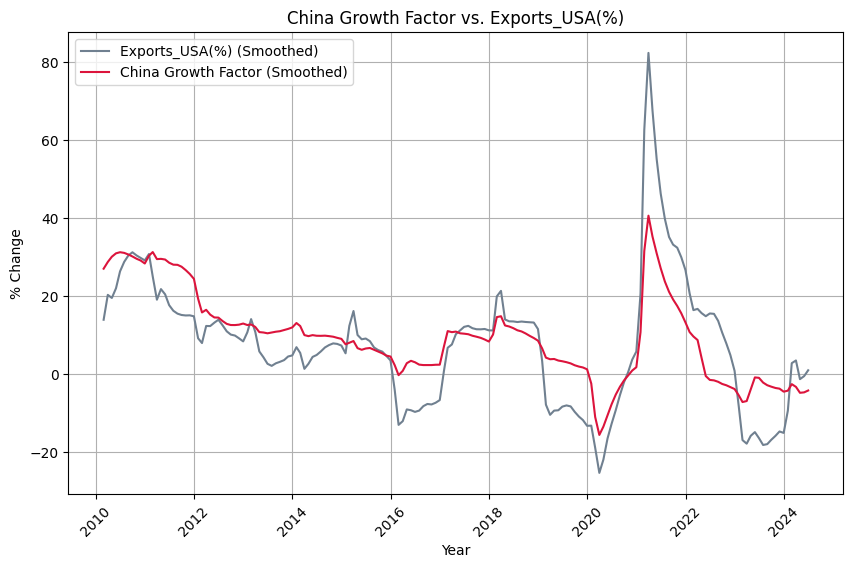

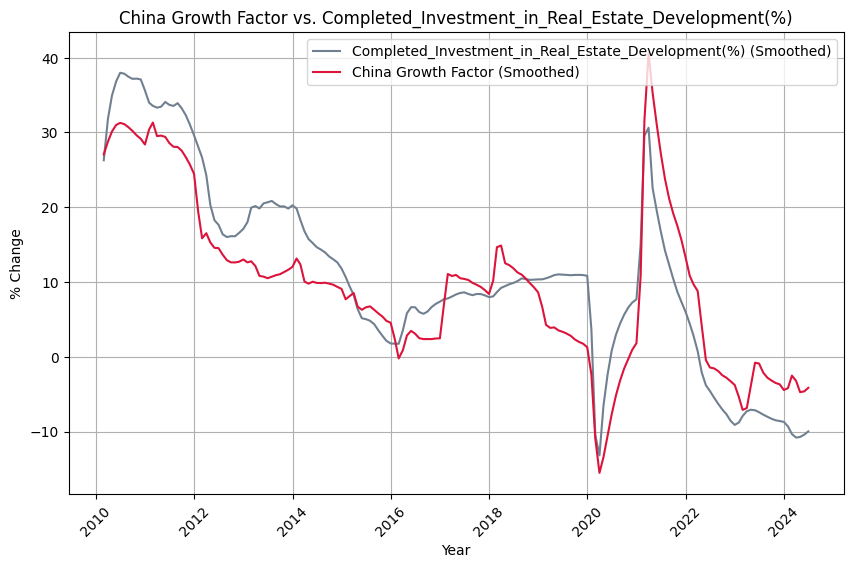

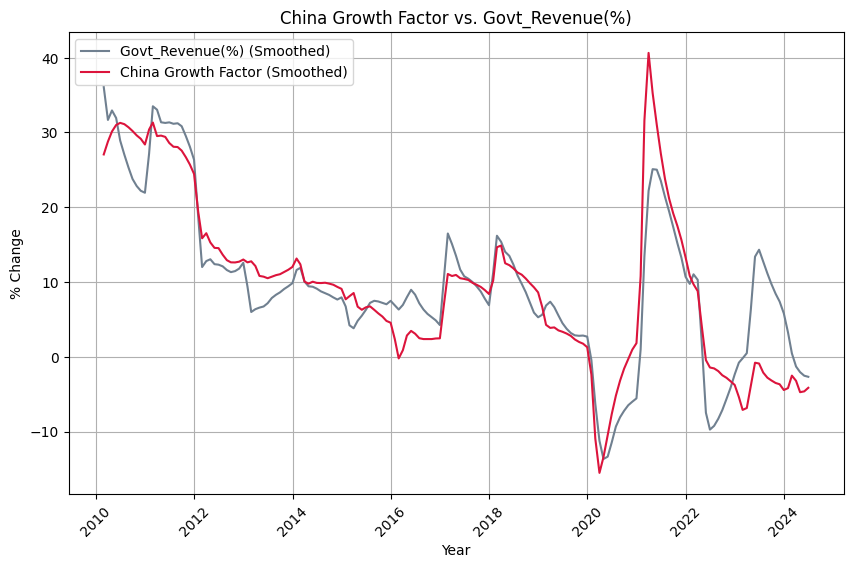

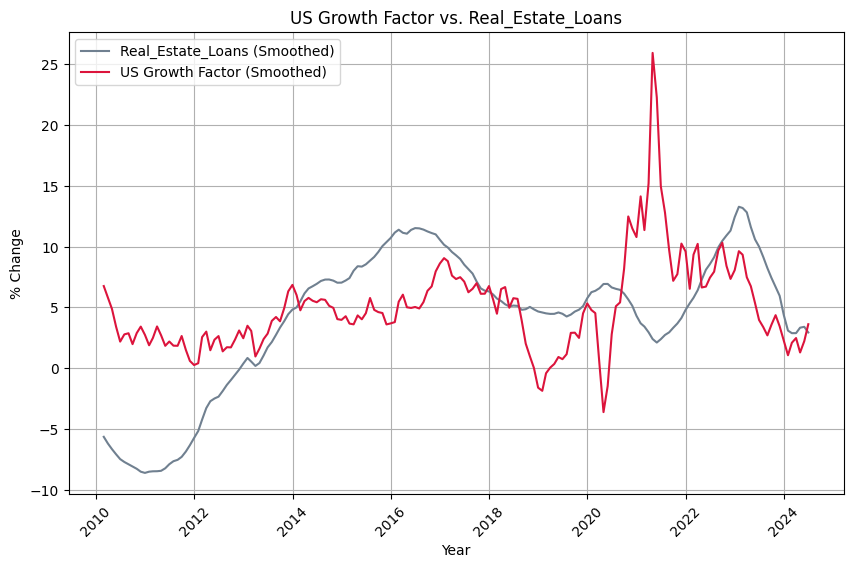

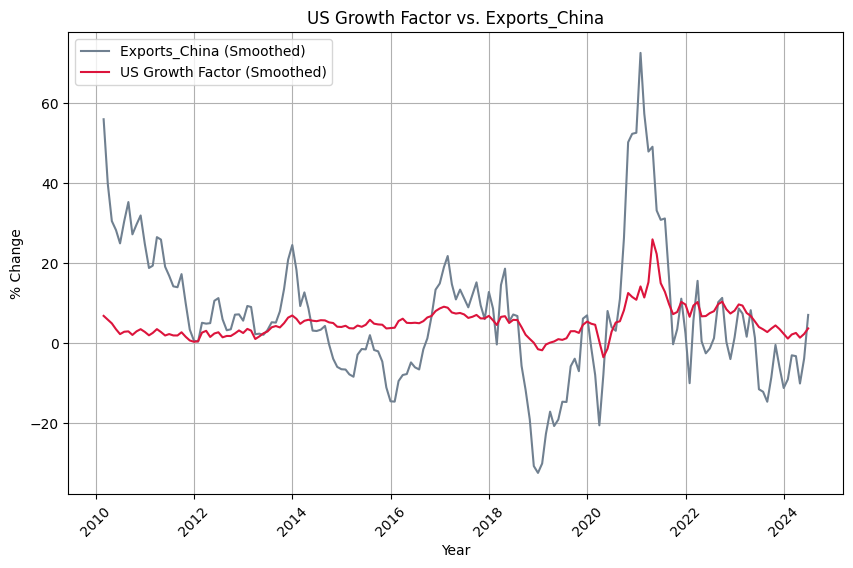

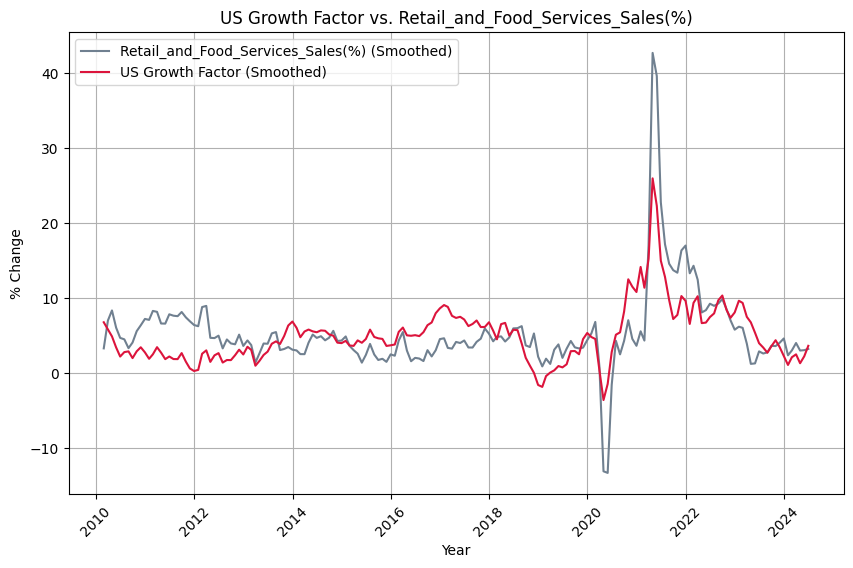

In [22]:
# Plot the data
for cg in china_growth_comps:
    plot_smoothed_data("China Growth", china_growth, df_china_growth, cg)
for usg in us_growth_comps:
    plot_smoothed_data("US Growth", us_growth, df_us_growth, usg)


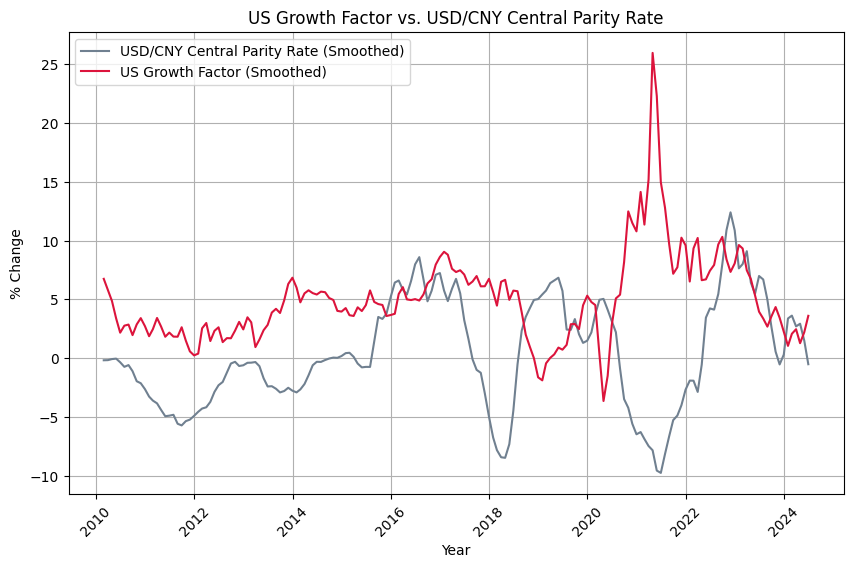

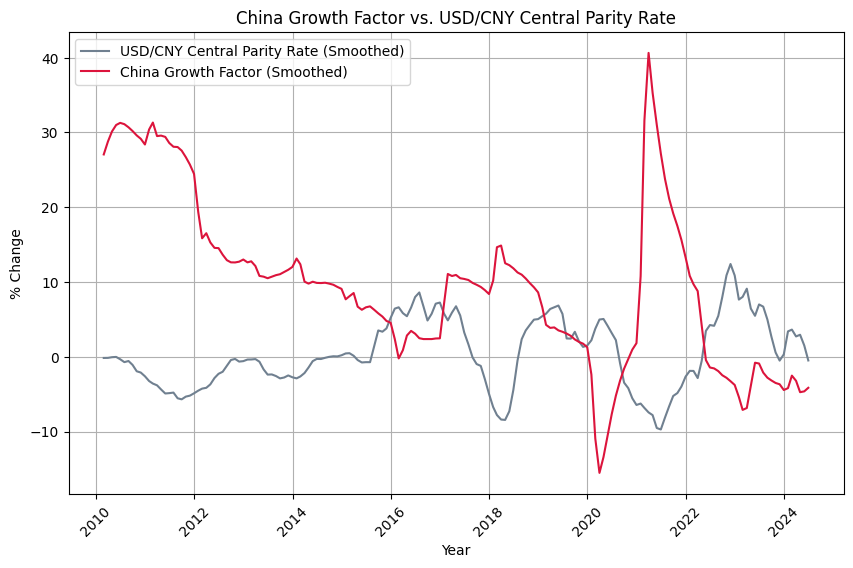

In [23]:
plot_smoothed_data("US Growth", us_growth, df_forex, "USD/CNY Central Parity Rate")
plot_smoothed_data("China Growth", china_growth, df_forex, "USD/CNY Central Parity Rate")

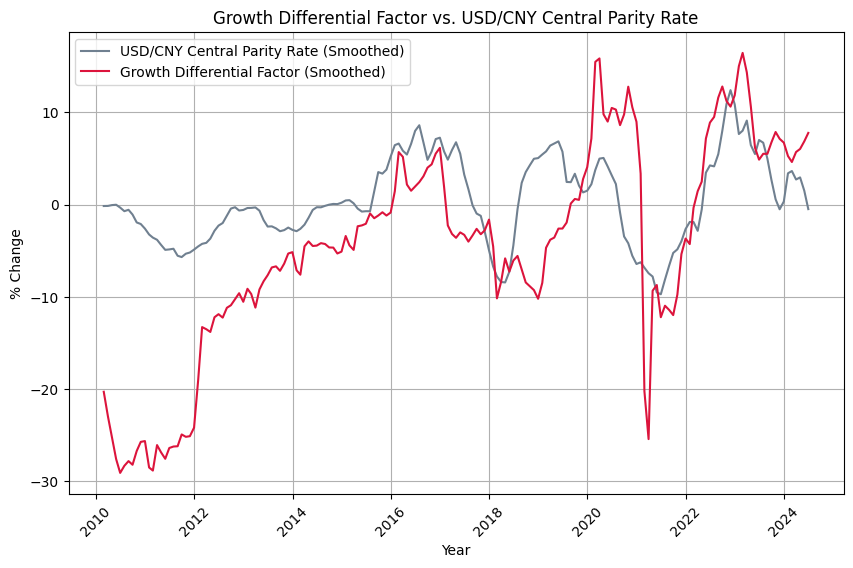

In [24]:
growth = us_growth - china_growth
# growth.to_csv("/Users/miaxiaozile/Downloads/$/forex-project/data/growth.csv", header=True)
plot_smoothed_data("Growth Differential", growth, df_forex, "USD/CNY Central Parity Rate")

## Inflation Factor

In [25]:
# Function to calculate rolling average and plot the data
def plot_inflation(target_df, df, column, window_size=2):
    # Calculate rolling average (smoothing)
    for target in target_df.columns:
        smoothed_serie = df[column].rolling(window=window_size).mean()
        smoothed_factor = target_df[target].rolling(window=window_size).mean()

        # Convert PeriodIndex to DatetimeIndex for plotting
        smoothed_serie.index = smoothed_serie.index.to_timestamp()
        smoothed_factor.index = smoothed_factor.index.to_timestamp()

        # Plotting the data
        plt.figure(figsize=(10, 6))
        plt.plot(smoothed_serie.index, smoothed_serie, label=f'{column} (Smoothed)', color="slategray")
        plt.plot(smoothed_factor.index, smoothed_factor, label=f'{target} (Smoothed)', color="crimson")
        plt.xlabel('Year')
        plt.ylabel('% Change')
        plt.title(f'{target} vs. {column}')
        plt.legend()
        plt.grid(True)
        
        # Format x-axis to show only year
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.xticks(rotation=45)
        
        plt.show()

In [26]:
china_inflation_targets = {
    "China_CPI":"M0000612",
    "China_PPI":"M0001227"
}

china_inflation_inds = {
    "Brent_Crude_Oil":"S0031525",
    "Pork":"S0066840",
    "Rebar": "S5707798",
    "Hot_Rolled_Coils":"S0066764",
    "Iron_Ore":"S5705176",
    "Steam_Coal":"S5104572",
    "Soybean":"S0117115",
    "Gold":"S0031645"
}

In [27]:
china_infl_targs = extract_inds(china_inflation_targets, "2010-01-01")
# china_infl_targs = lag_data(china_infl_targs)
china_infl_targs = apply_x11(china_infl_targs, china_infl_targs.columns)
china_infl_targs

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


,China_CPI,China_PPI
2010-01-31,1.837512,4.443685
2010-02-28,2.899319,5.347505
2010-03-31,2.447906,5.845143
2010-04-30,2.787646,6.833153
2010-05-31,3.090086,7.253474
...,...,...
2024-02-29,1.032650,-2.744403
2024-03-31,0.110148,-2.831099
2024-04-30,0.277505,-2.634997
2024-05-31,0.177758,-1.162568


In [28]:
china_infl_df = extract_inds_irr(china_inflation_inds)
# china_infl_df = lag_data(china_infl_df) # lag data by 1 period
china_infl_df = china_infl_df.interpolate(method="linear")  # interpolate missing values
china_infl_df = apply_x11(china_infl_df, china_infl_df.columns)
china_infl_df = yoy(china_infl_df, china_infl_df.columns)
china_infl_df

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


,Brent_Crude_Oil,Pork,Rebar,Hot_Rolled_Coils,Iron_Ore,Steam_Coal,Soybean,Gold
2010-01,52.839163,-20.415602,-0.129420,-3.106923,60.168456,35.477706,18.078781,16.768136
2010-02,73.779586,1.233752,6.352772,7.626902,100.394604,29.822573,15.669323,16.261009
2010-03,76.241462,-8.239836,27.098664,24.266444,164.160160,21.650830,13.147069,21.181125
2010-04,92.238685,-4.798688,27.564087,42.336675,188.523457,21.650379,8.798373,33.813297
2010-05,14.588281,-3.258220,14.882680,26.882992,120.544696,29.387777,3.150509,24.365619
...,...,...,...,...,...,...,...,...
2024-03,9.254529,10.578262,-16.221425,-14.063333,-20.099520,-1.379082,-18.217424,11.499824
2024-04,10.006430,3.675558,-1.734449,-3.852724,10.282983,-2.300248,-20.154252,16.013308
2024-05,12.897050,25.730417,4.033588,2.953972,14.158413,-1.604933,-20.888890,19.121573
2024-06,17.199329,30.962409,-5.596499,-3.761687,-3.457663,-0.802781,-17.026030,21.601084


In [29]:
china_infl_cpi = regress(china_infl_df.iloc[:-1], china_infl_targs, "China_CPI")
china_infl_cpi

,Indicator,Beta,T-Value,R-Squared(%)
0,Brent_Crude_Oil,0.00,0.52,2.37%
1,Gold,0.03,1.79,12.82%
2,Hot_Rolled_Coils,-0.00,-0.04,1.13%
3,Iron_Ore,0.00,0.44,1.88%
4,Pork,0.02,4.00,33.68%
5,Rebar,0.00,0.12,1.41%
6,Soybean,0.02,0.91,5.69%
7,Steam_Coal,0.00,0.28,1.03%


In [30]:
china_infl_ppi = regress(china_infl_df.iloc[:-1], china_infl_targs, "China_PPI")
china_infl_ppi

,Indicator,Beta,T-Value,R-Squared(%)
0,Brent_Crude_Oil,0.10,8.82,69.93%
1,Gold,0.07,1.34,5.07%
2,Hot_Rolled_Coils,0.13,4.76,46.14%
3,Iron_Ore,0.05,3.03,20.03%
4,Pork,-0.02,-1.31,5.76%
5,Rebar,0.14,5.69,55.81%
6,Soybean,0.18,7.20,56.58%
7,Steam_Coal,0.18,5.51,58.41%


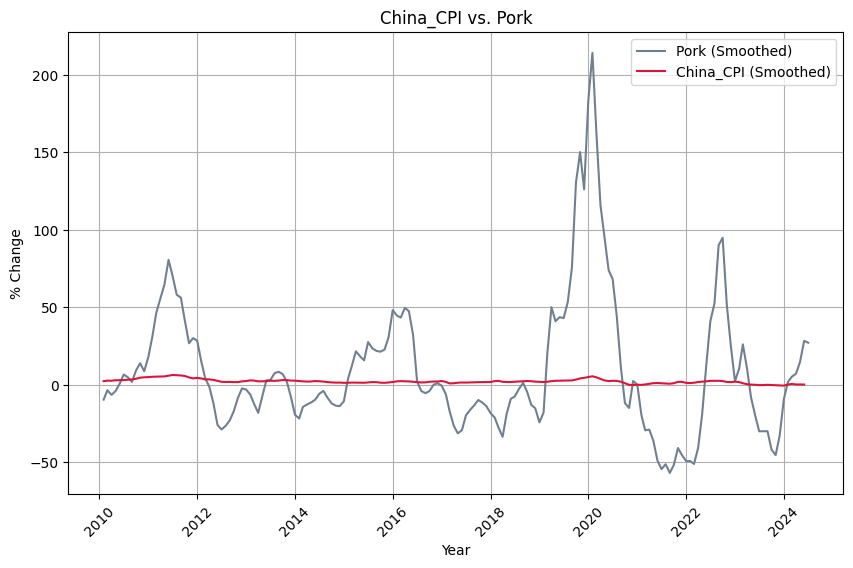

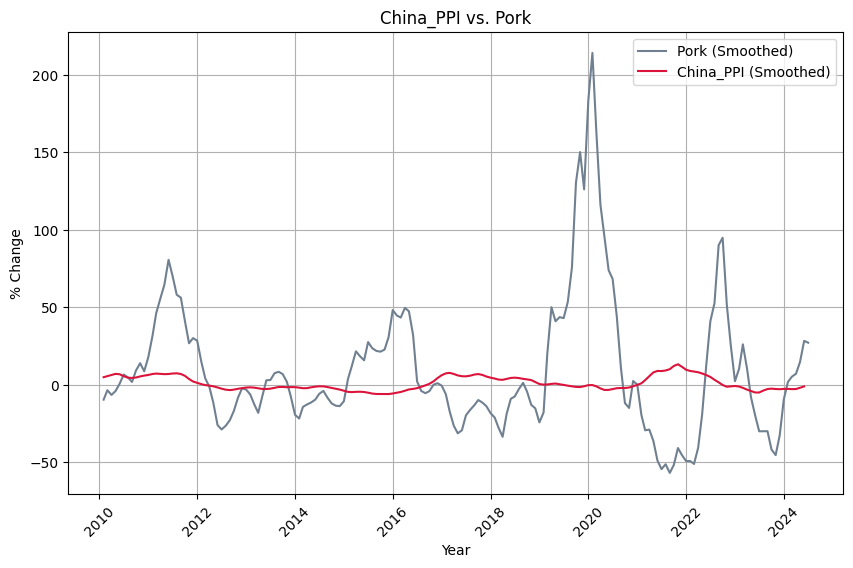

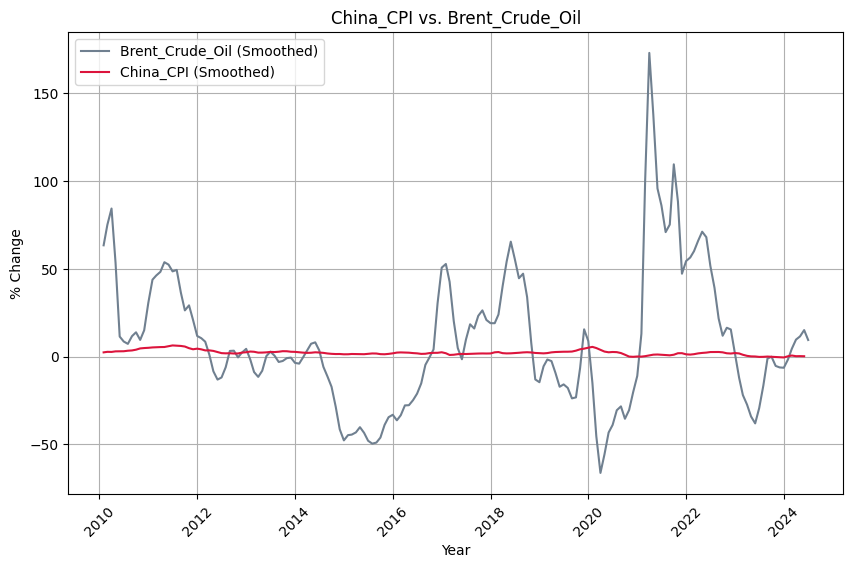

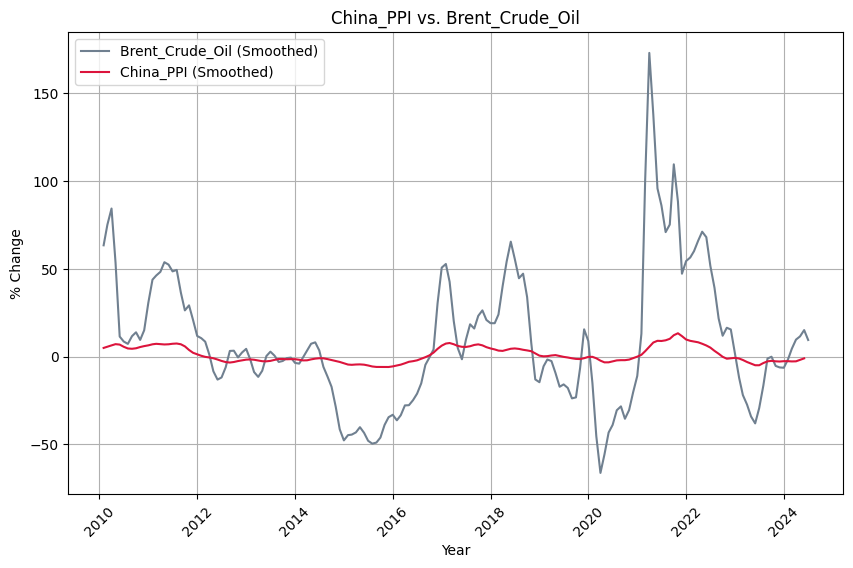

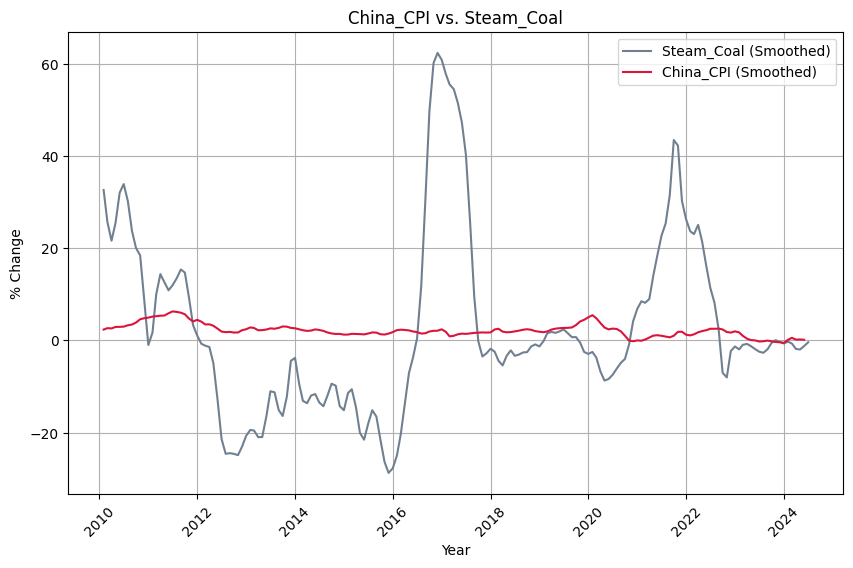

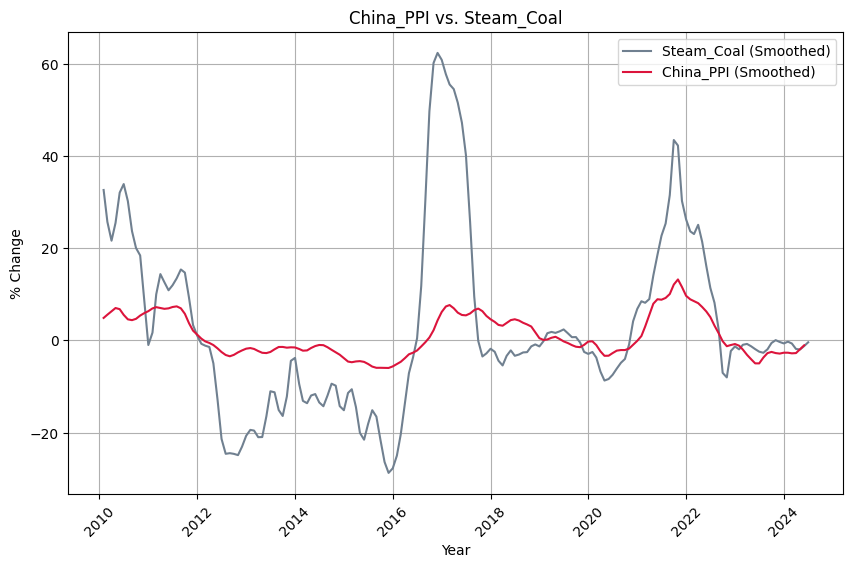

In [31]:
china_infl_comps = ["Pork", "Brent_Crude_Oil", "Steam_Coal"]
for comp in china_infl_comps:
    plot_inflation(china_infl_targs, china_infl_df, comp)

In [32]:
us_inflation_targets = {
    "US_CPI":"G0000027",
    "US_PPI":"G1188690"
}

us_inflation_inds = {
    "Brent_Crude_Oil":"S0031525",
    "Eggs":"D5210303",
    "Soybean":"S0117115",
    "Gold":"S0031645",
    "Natural_Gas":"S0048357",
    "Hot_Rolled_Coils":"S0143115"
}

us_preprocess_cols = ["Brent_Crude_Oil", "Gold", "Soybean", "Natural_Gas", "Hot_Rolled_Coils"]

In [33]:
us_infl_targs = extract_inds(us_inflation_targets, "2010-01-01")
# us_infl_targs = lag_data(us_infl_targs)
us_infl_targs = apply_x11(us_infl_targs, us_infl_targs.columns)
us_infl_targs

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)


,US_CPI,US_PPI
2010-01-31,2.700855,7.599262
2010-02-28,2.160003,7.781161
2010-03-31,2.193330,9.336307
2010-04-30,2.034375,9.901194
2010-05-31,1.939387,8.921329
...,...,...
2024-02-29,3.141884,-1.111614
2024-03-31,3.424473,-0.563040
2024-04-30,3.287333,0.211476
2024-05-31,3.265584,0.851208


In [34]:
us_infl_df = extract_inds_irr(us_inflation_inds)
# us_infl_df = lag_data(us_infl_df)
us_infl_df = us_infl_df.interpolate(method="linear")
us_infl_df = apply_x11(us_infl_df, us_preprocess_cols)
us_infl_df = yoy(us_infl_df, us_preprocess_cols)
us_infl_df

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


,Brent_Crude_Oil,Eggs,Soybean,Gold,Natural_Gas,Hot_Rolled_Coils
2010-01,52.839163,-6.56,18.078781,16.768136,-14.925410,-15.232268
2010-02,73.779586,-1.00,15.669323,16.261009,-12.232929,-20.426269
2010-03,76.241462,3.51,13.147069,21.181125,-7.540622,-17.410893
2010-04,92.238685,-1.44,8.798373,33.813297,2.122226,4.124105
2010-05,14.588281,-0.54,3.150509,24.365619,1.649159,10.949603
...,...,...,...,...,...,...
2024-03,9.254529,-7.74,-18.217424,11.499824,-0.043472,-2.467081
2024-04,10.006430,-3.71,-20.154252,16.013308,3.052308,-5.262864
2024-05,12.897050,0.32,-20.888890,19.121573,-10.852803,-5.319011
2024-06,17.199329,0.32,-17.026030,21.601084,-25.963981,-5.258856


In [35]:
us_infl_cpi = regress(us_infl_df.iloc[:-1], us_infl_targs, "US_CPI")
us_infl_cpi

,Indicator,Beta,T-Value,R-Squared(%)
0,Brent_Crude_Oil,0.03,3.19,33.23%
1,Eggs,0.05,1.90,17.88%
2,Gold,-0.00,-0.06,1.42%
3,Hot_Rolled_Coils,0.05,4.02,36.30%
4,Natural_Gas,0.11,2.85,36.01%
5,Soybean,0.06,3.47,35.50%


In [36]:
us_infl_ppi = regress(us_infl_df.iloc[:-1], us_infl_targs, "US_PPI")
us_infl_ppi

,Indicator,Beta,T-Value,R-Squared(%)
0,Brent_Crude_Oil,0.18,7.30,75.87%
1,Eggs,0.11,1.40,6.26%
2,Gold,0.01,0.15,1.42%
3,Hot_Rolled_Coils,0.30,8.30,73.56%
4,Natural_Gas,0.49,4.01,45.55%
5,Soybean,0.34,6.92,67.16%


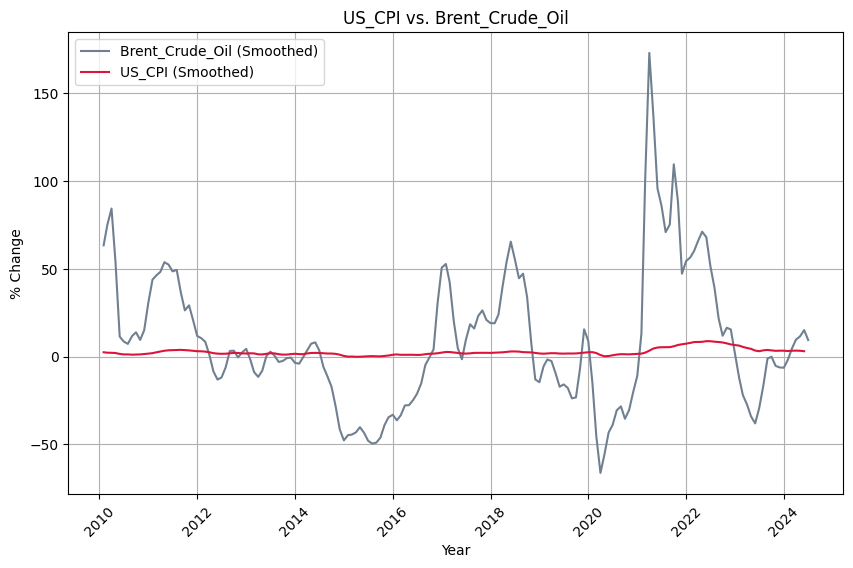

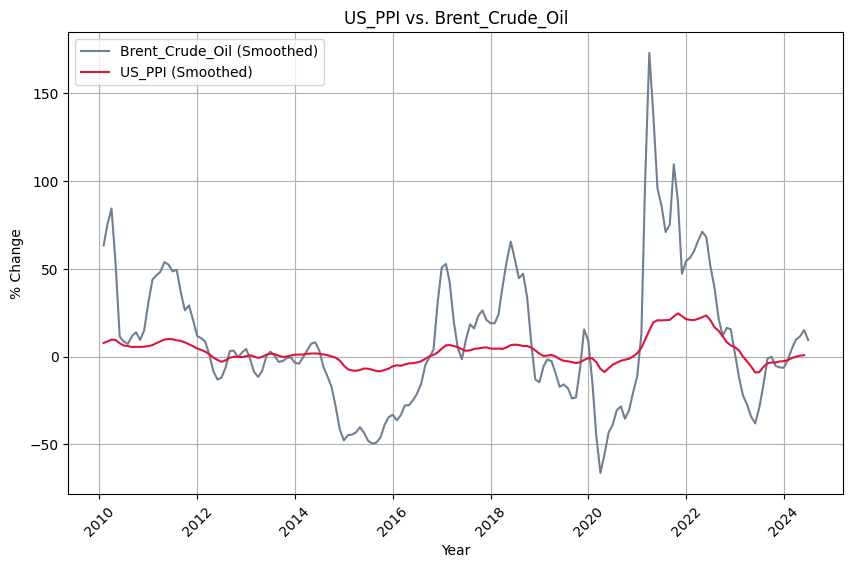

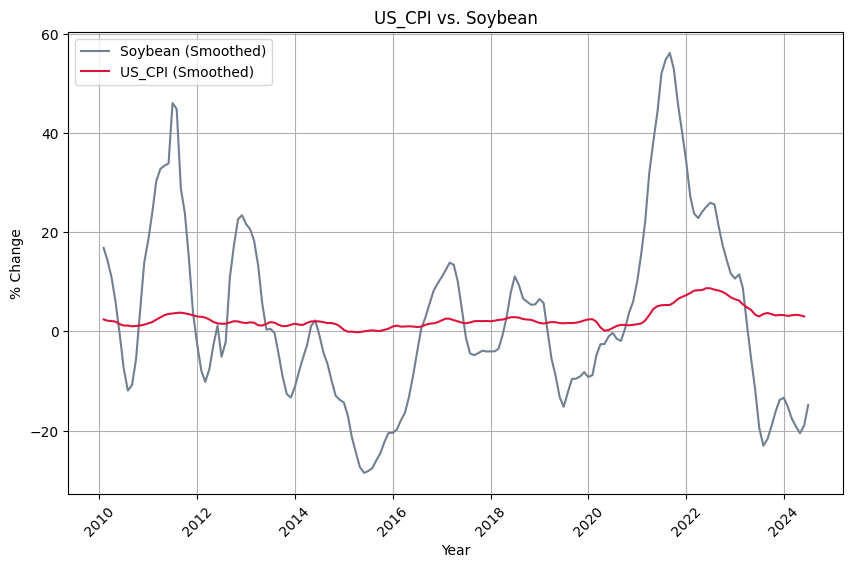

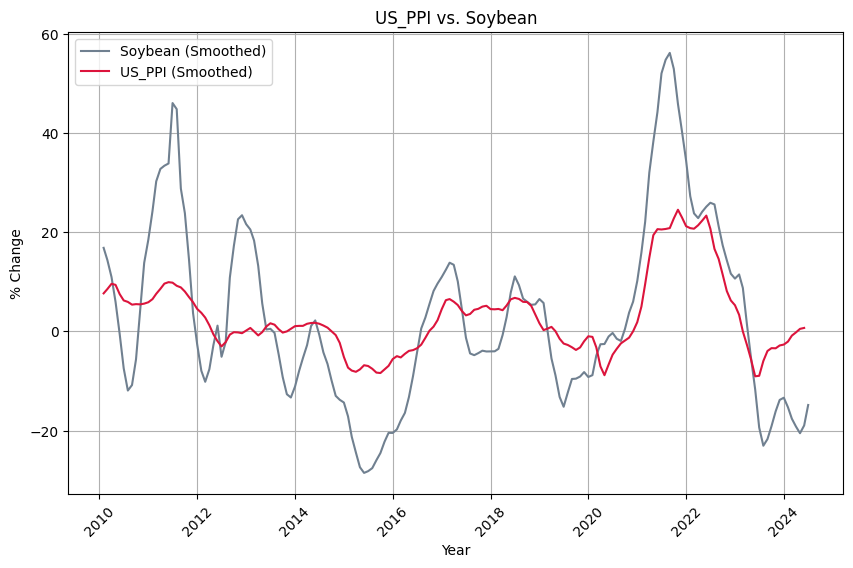

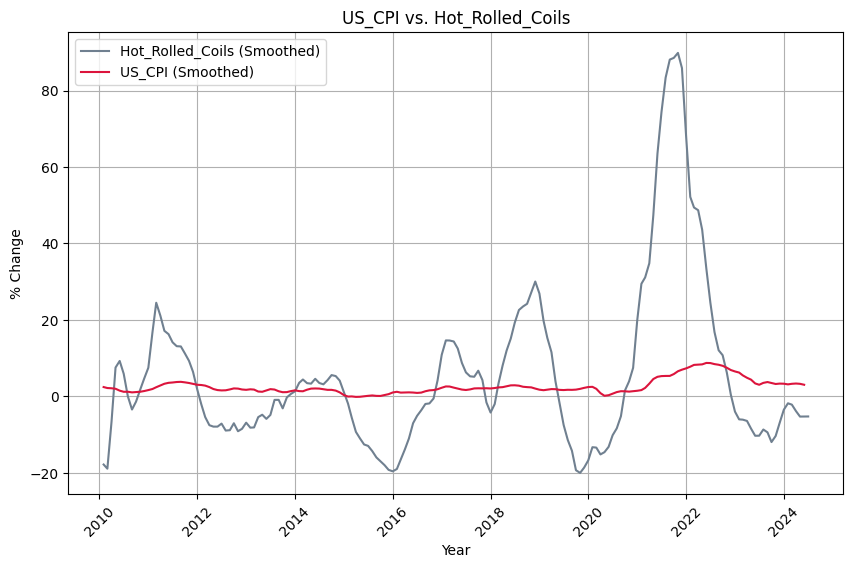

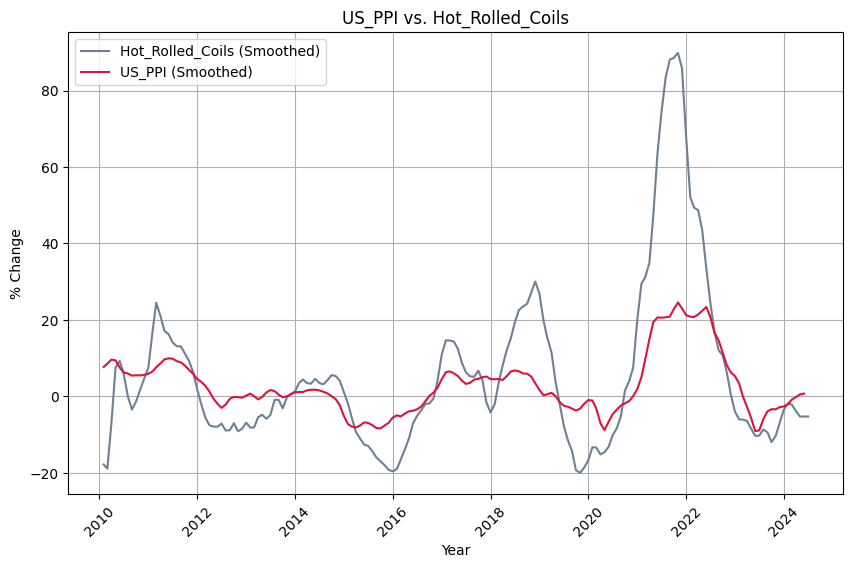

In [37]:
us_infl_comps = ["Brent_Crude_Oil", "Soybean", "Hot_Rolled_Coils"]
for comp in us_infl_comps:
    plot_inflation(us_infl_targs, us_infl_df, comp)

In [38]:
china_inflation, weights = combine_factors(china_infl_df, china_infl_comps)
us_inflation, weights = combine_factors(us_infl_df, us_infl_comps)

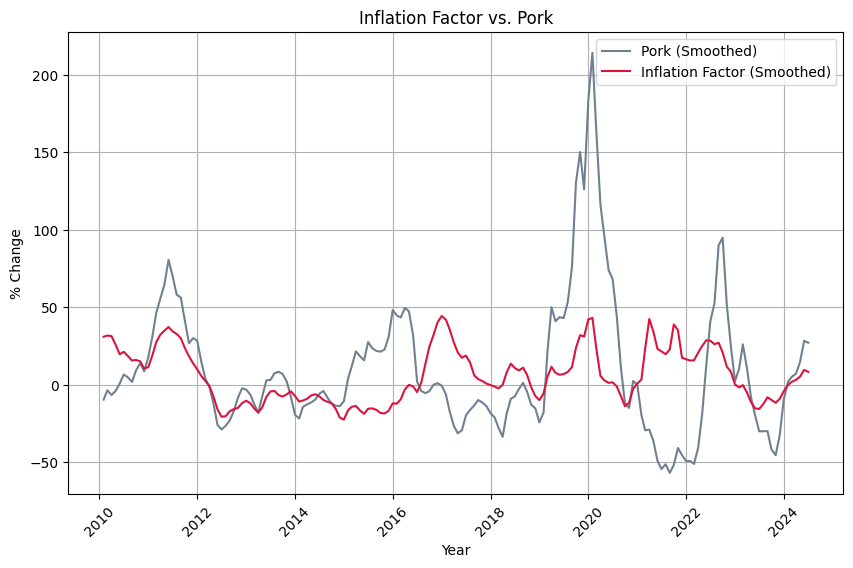

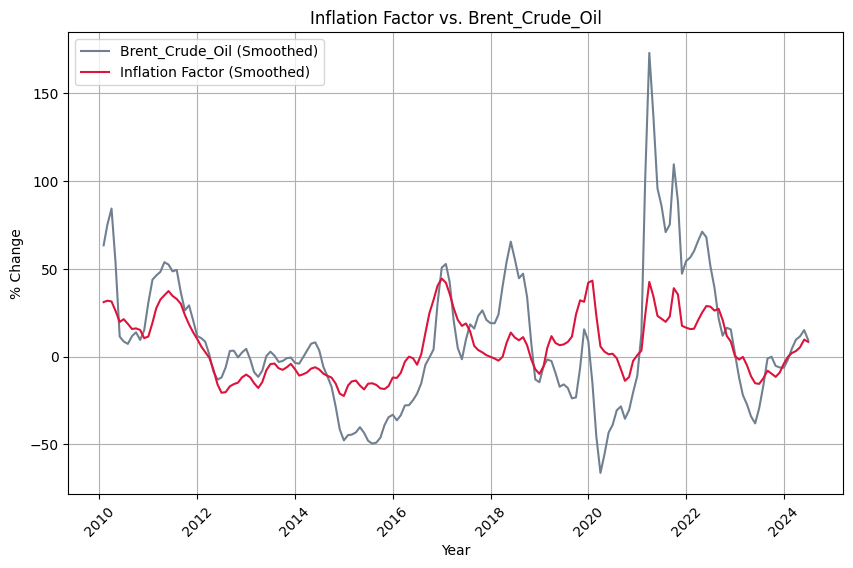

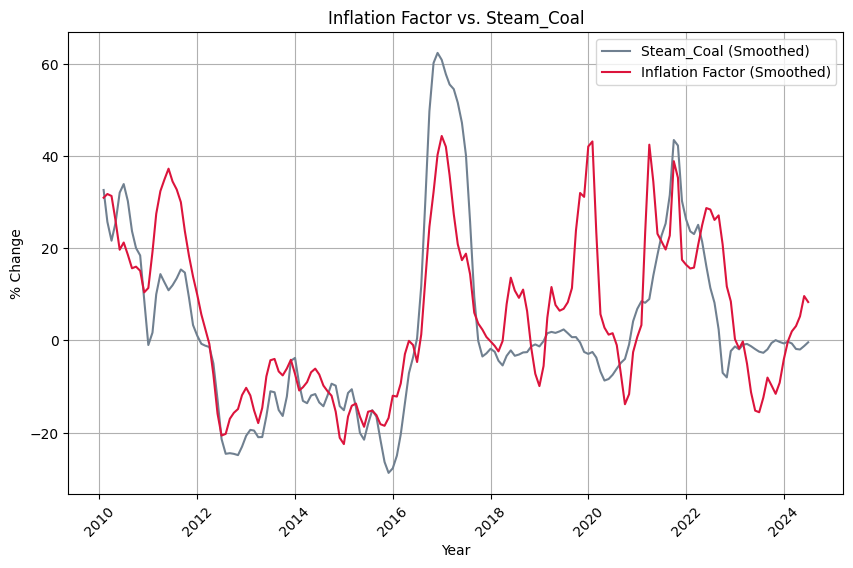

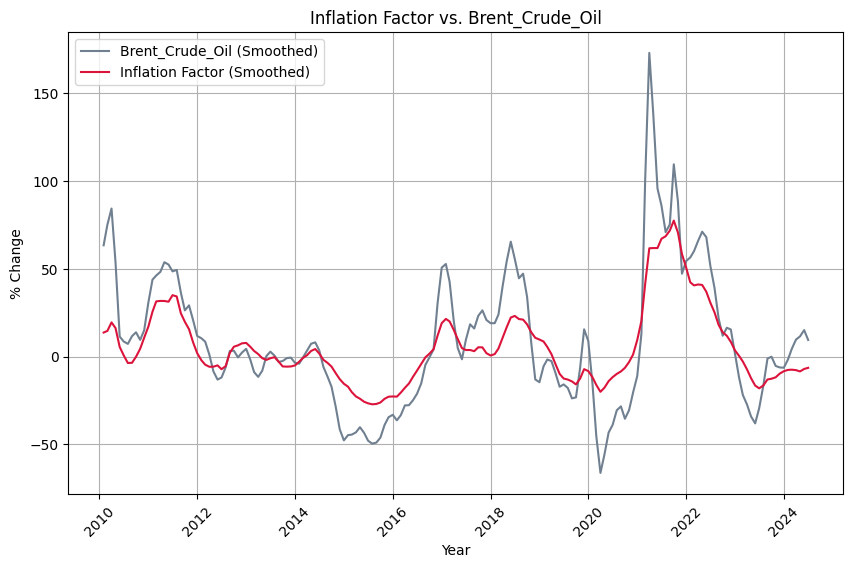

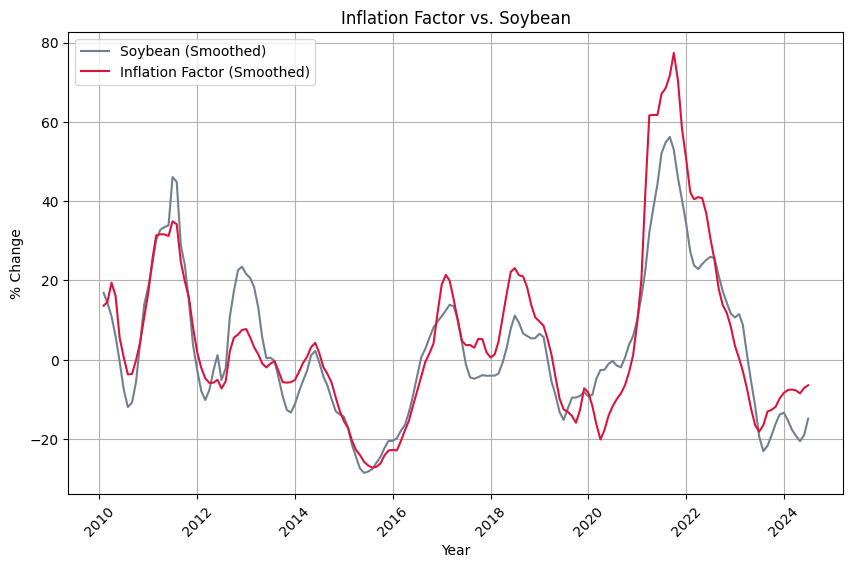

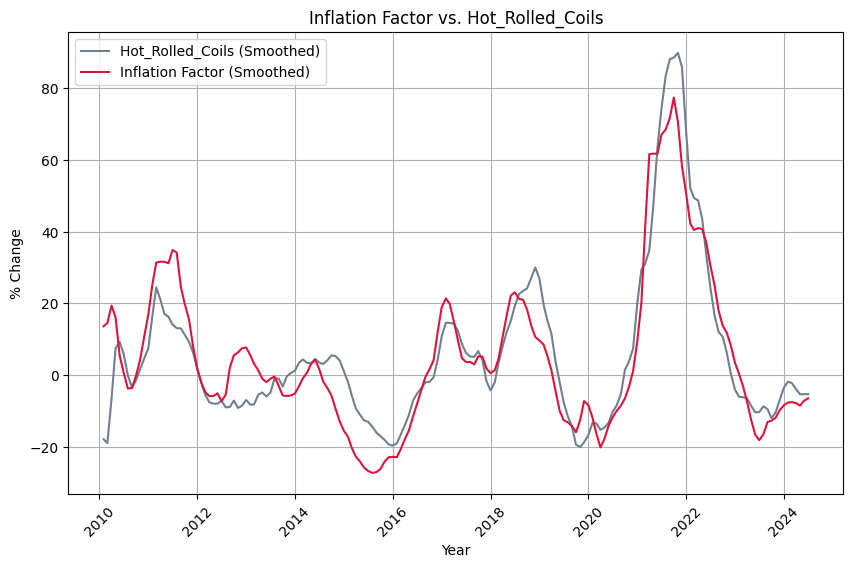

In [39]:
# Plot the data
for cg in china_infl_comps:
    plot_smoothed_data("Inflation", china_inflation, china_infl_df, cg)
for usg in us_infl_comps:
    plot_smoothed_data("Inflation", us_inflation, us_infl_df, usg)

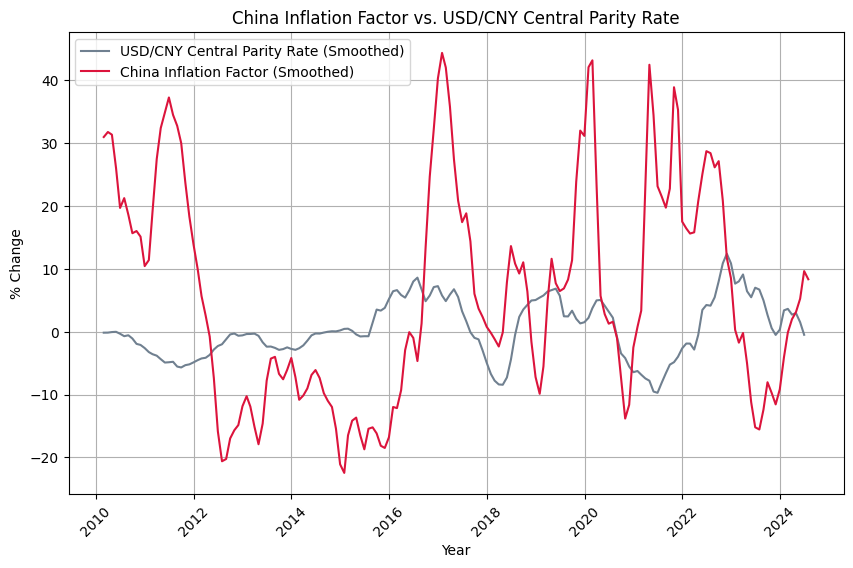

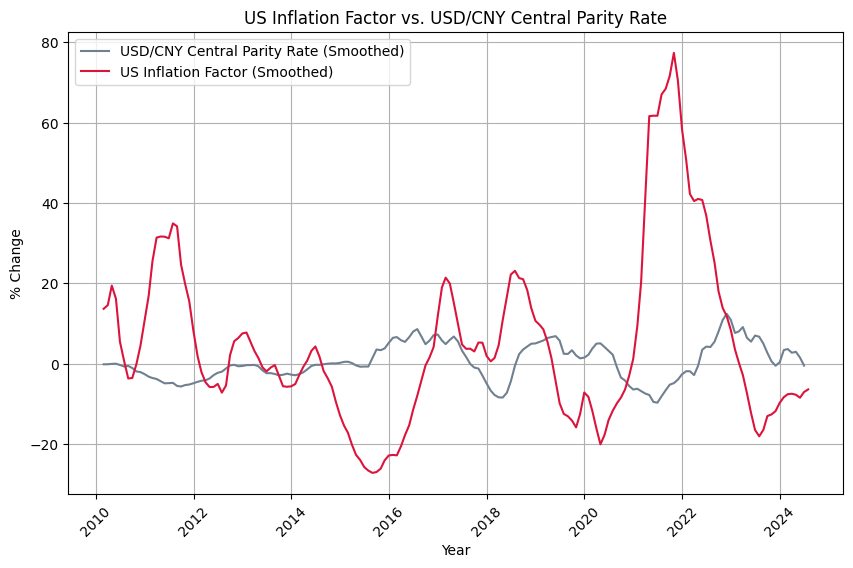

In [40]:
plot_smoothed_data("China Inflation", china_inflation, df_forex, "USD/CNY Central Parity Rate")
plot_smoothed_data("US Inflation", us_inflation, df_forex, "USD/CNY Central Parity Rate")

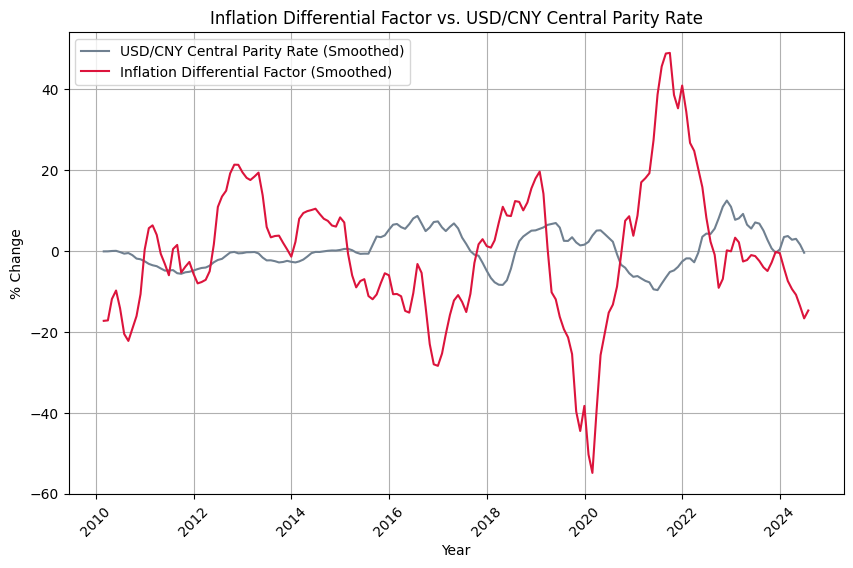

In [41]:
inflation = us_inflation - china_inflation
# inflation.to_csv("/Users/miaxiaozile/Downloads/$/forex-project/data/inflation.csv", header=True)
plot_smoothed_data("Inflation Differential", inflation, df_forex, "USD/CNY Central Parity Rate")

## Interest Factor

In [42]:
china_interest_inds = {
    # money market rates
    "R007":"M0041653",
    "FR007":"M0017153",
    "IBO007":"M0041664",
    "SHIBOR(3M)":"M0017142",
    # bonds market rates
    "China_Govt_Bond(1M)":"M1004677",
    "China_Govt_Bond(3M)":"S0059741",
    "China_Govt_Bond(1Y)":"S0059744",
    "China_Govt_Bond(3Y)":"S0059746",
    "China_Govt_Bond(5Y)":"S0059747",
    "China_Govt_Bond(7Y)":"S0059748",
    "China_Govt_Bond(10Y)":"S0059749"
}

In [43]:
china_int_df = extract_inds_irr(china_interest_inds, "2010-01-01")
china_int_df

,R007,FR007,IBO007,SHIBOR(3M),China_Govt_Bond(1M),China_Govt_Bond(3M),China_Govt_Bond(1Y),China_Govt_Bond(3Y),China_Govt_Bond(5Y),China_Govt_Bond(7Y),China_Govt_Bond(10Y)
2010-01,1.8639,1.8913,1.8826,1.9048,1.1965,1.2659,1.6529,2.5063,3.0013,3.2838,3.5800
2010-02,1.6761,1.6700,1.6735,1.9443,1.2120,1.3244,1.6294,2.4566,2.8654,3.1283,3.3753
2010-03,1.6022,1.6100,1.7066,1.9419,1.1315,1.2112,1.5501,2.3318,2.7923,3.0815,3.4818
2010-04,1.6005,1.6000,1.6616,1.9398,1.2361,1.3186,1.5892,2.3059,2.6387,3.0125,3.3565
2010-05,2.5135,2.5100,2.4490,2.1201,1.6646,1.7090,1.8162,2.3039,2.4885,2.8929,3.2430
...,...,...,...,...,...,...,...,...,...,...,...
2024-03,2.8088,2.3000,2.1246,2.1560,1.6245,1.6414,1.7225,2.0315,2.1974,2.3175,2.2901
2024-04,2.0899,2.1000,2.1355,2.0020,1.4925,1.5342,1.6928,1.9836,2.1484,2.2822,2.3028
2024-05,1.8655,1.8800,1.8187,1.9550,1.4916,1.5428,1.6444,1.9360,2.0850,2.2526,2.2926
2024-06,2.4492,2.3000,2.0675,1.9180,1.3491,1.4411,1.5390,1.7960,1.9782,2.1030,2.2058


In [44]:
china_int_ctrb = regress(china_int_df, df_fx_nonyoy)
china_int_ctrb

,Indicator,Beta,T-Value,R-Squared(%)
0,China_Govt_Bond(10Y),-0.43,-5.48,42.51%
1,China_Govt_Bond(1M),-0.28,-5.26,41.29%
2,China_Govt_Bond(1Y),-0.31,-4.26,34.56%
3,China_Govt_Bond(3M),-0.30,-4.77,38.09%
4,China_Govt_Bond(3Y),-0.38,-5.16,39.90%
5,China_Govt_Bond(5Y),-0.41,-5.36,41.98%
6,China_Govt_Bond(7Y),-0.44,-5.62,42.81%
7,FR007,-0.16,-3.06,24.80%
8,IBO007,-0.16,-3.23,24.80%
9,R007,-0.16,-3.25,23.85%


In [45]:
us_interest_inds = {
    # money market rates
    "Fed_Target":"M0000162",
    "LIBOR(3M)":"G0000898",
    # bonds market rates
    "Treasury_Yields(1M)":"G0000883",
    "Treasury_Yields(3M)":"G0000884",
    "Treasury_Yields(1Y)":"G0000886",
    "Treasury_Yields(3Y)":"G0000888",
    "Treasury_Yields(5Y)":"G0000889",
    "Treasury_Yields(7Y)":"G0000890",
    "Treasury_Yields(10Y)":"G0000891"
}

In [46]:
us_int_df = extract_inds_irr(us_interest_inds, "2010-01-01").sort_index()
us_int_df = us_int_df.ffill().fillna(0.25)
us_int_df

,Fed_Target,LIBOR(3M),Treasury_Yields(1M),Treasury_Yields(3M),Treasury_Yields(1Y),Treasury_Yields(3Y),Treasury_Yields(5Y),Treasury_Yields(7Y),Treasury_Yields(10Y)
2010-01,0.25,0.24906,0.02,0.08,0.30,1.38,2.34,3.08,3.63
2010-02,0.25,0.25169,0.09,0.13,0.32,1.36,2.30,3.05,3.61
2010-03,0.25,0.29150,0.15,0.16,0.41,1.60,2.55,3.28,3.84
2010-04,0.25,0.34656,0.14,0.16,0.41,1.51,2.43,3.12,3.69
2010-05,0.25,0.53625,0.15,0.16,0.34,1.26,2.10,2.75,3.31
...,...,...,...,...,...,...,...,...,...
2024-03,5.50,5.55984,5.49,5.46,5.03,4.40,4.21,4.20,4.20
2024-04,5.50,5.58975,5.48,5.46,5.25,4.87,4.72,4.71,4.69
2024-05,5.50,5.60445,5.48,5.46,5.18,4.69,4.52,4.52,4.51
2024-06,5.50,5.58621,5.47,5.48,5.09,4.52,4.33,4.33,4.36


In [47]:
us_int_ctrb = regress(us_int_df, df_fx_nonyoy)
us_int_ctrb

,Indicator,Beta,T-Value,R-Squared(%)
0,Fed_Target,0.14,6.75,47.98%
1,LIBOR(3M),0.14,6.97,49.77%
2,Treasury_Yields(10Y),0.13,1.89,13.99%
3,Treasury_Yields(1M),0.13,6.91,48.24%
4,Treasury_Yields(1Y),0.14,6.86,47.23%
5,Treasury_Yields(3M),0.13,6.99,48.47%
6,Treasury_Yields(3Y),0.16,5.71,41.18%
7,Treasury_Yields(5Y),0.17,3.96,32.18%
8,Treasury_Yields(7Y),0.16,2.83,23.62%


In [48]:
china_int_comps = ["SHIBOR(3M)", "China_Govt_Bond(10Y)"]
us_int_comps = ["LIBOR(3M)", "Treasury_Yields(3M)"]
china_interest, weights = combine_factors(china_int_df, china_int_comps)
us_interest, weights = combine_factors(us_int_df, us_int_comps)

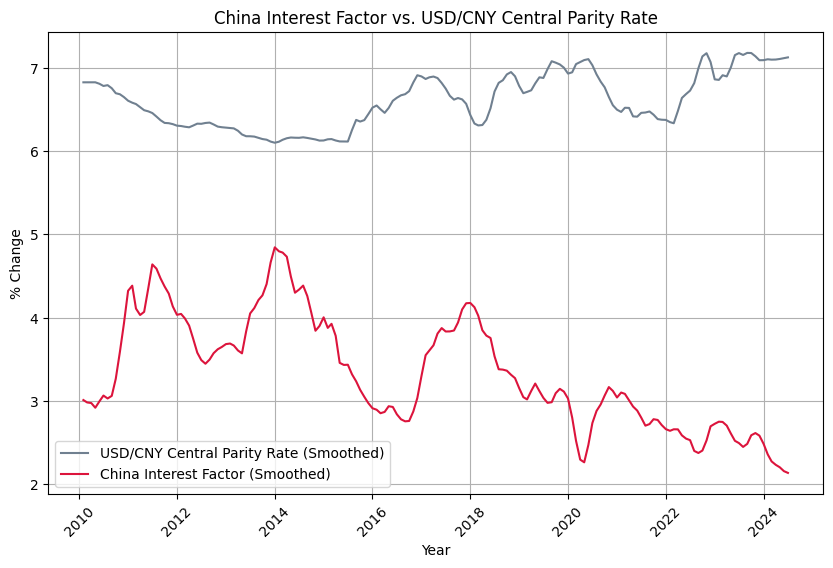

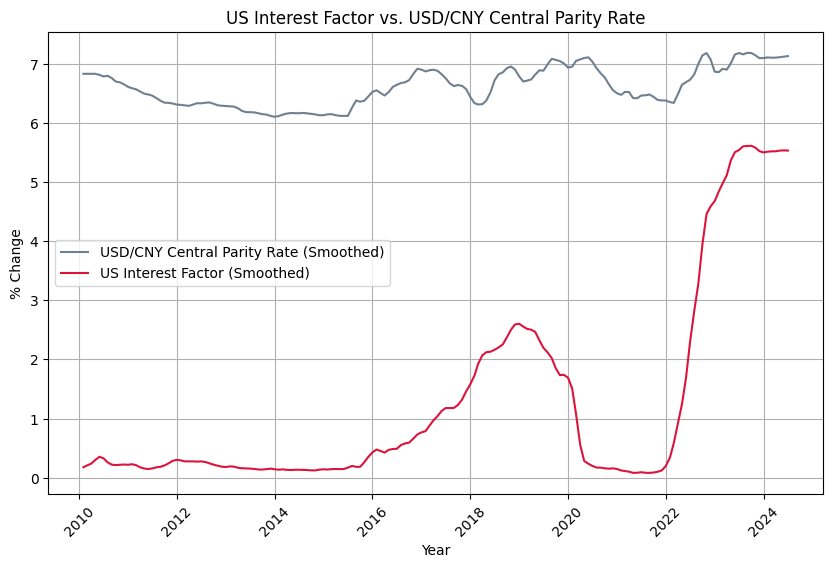

In [49]:
plot_smoothed_data("China Interest", china_interest, df_fx_nonyoy, "USD/CNY Central Parity Rate")
plot_smoothed_data("US Interest", us_interest, df_fx_nonyoy, "USD/CNY Central Parity Rate")

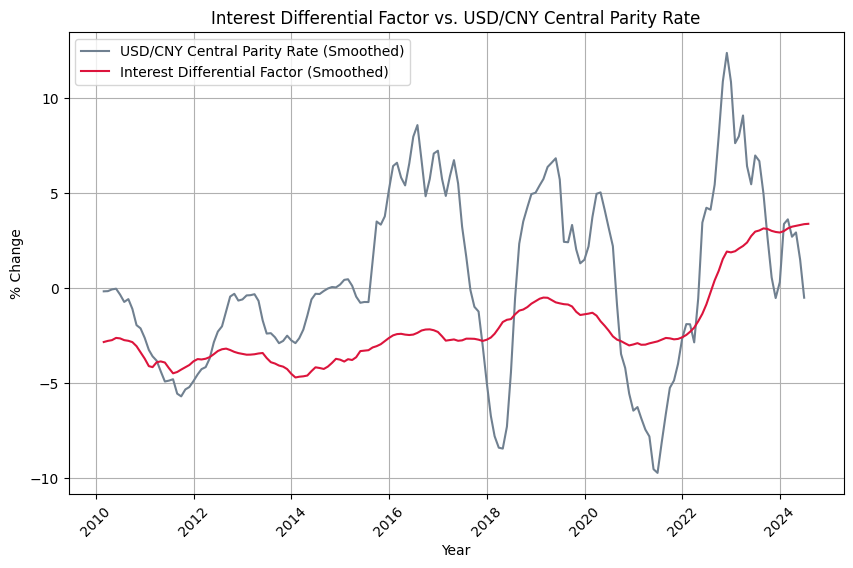

connect And Re login ip:njdxsky.wind.com.cn usPort:443connect And Re login ip:njdxsky.wind.com.cn usPort:443

In [51]:
interest = us_interest - china_interest
# interest.to_csv("/Users/miaxiaozile/Downloads/$/forex-project/data/interest.csv", header=True)
plot_smoothed_data("Interest Differential", interest, df_forex, "USD/CNY Central Parity Rate")